# An overview of the implemented algorithm 

The idea is to use Ant Colony Optmisation to solve the Traveling Salesman Problem, that is to find the shortest Hamiltonian circuit in a complete graph. 

First of all, a brief description of the parameters:

`alpha`: exponent of the pheromone

`beta`: exponent of the herustic information

`alpha_rate`: coefficent that multiplies alpha every `rate` iterations

`beta_rate`: coefficent that multiplies beta every `rate` iterations

`rho`: coefficient to regulate the dissolving of the pheromone

`max_iter`: number of iterations to perform

`k`: number of ants (i.e. paths created) at each iteration

`heuristic cost`: parameter to initialise the pheromone

`update_steps`: for how many iterations to continue update alpha and beta

`elitism`: wheter or not to leverage elitism, i.e. compute the pheromone using only half of the paths (the best half)

`elitism_steps`: how many steps to wait before to start using elitism, we noticed that it is useful to leverage elitism after a warming-up phase


In the following notebook, we show how to use the algorithm, demonstrate its convergence and show the importance of every component of the algorithm (i.e. the pheromone and heuristic information, the numerical stability and the choice and update of the parameters and their influence on the velocity of the algorithm to converge).

In [1]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import networkx as nx
import tsplib95

We choose to showcase our algorithm solving the att48 problem, which aims to find the shortest hamiltonian circuit to visit 48 capitals of the US.

In [2]:
problem = tsplib95.load("tsp_problems/att48.tsp")
graph = problem.get_graph()
# remove self loops
graph.remove_edges_from(nx.selfloop_edges(graph))
# rename nodes to start from 0
graph = nx.relabel_nodes(graph, {node: node-1 for node in graph.nodes})
print("Nodes in graph:", graph.nodes)
print("Edges in graph:", graph.edges)

Nodes in graph: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
Edges in graph: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), 

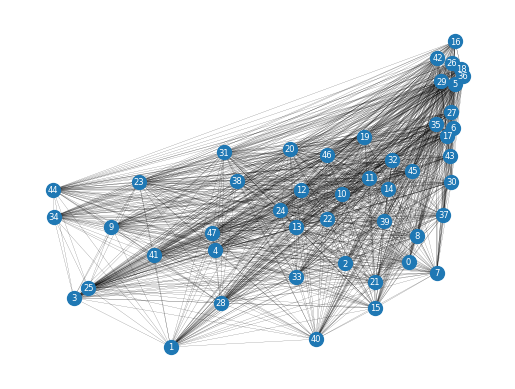

In [3]:
plot_graph(graph, title="")

## Collecting some statistics

The first useful statistic is the expected lenght of a hamiltonian circuit in the first iterations of our algorithm: this information is important to initialise correctly the pheromone and to have a "smooth" update of it.

In [4]:
# compute mean distance of a path between all nodes and the distance between nodes
mean_distance = 0
n = len(graph.nodes)
for i in range(n):
    neighbours = get_neighbours(graph, i)
    mean_distance += np.mean([graph[i][n]['weight'] for n in neighbours])
    
print(mean_distance)
mean_edge = mean_distance/n
print(mean_edge)

max_v = 0
min_v = 100000
for i in range(n):
    neighbours = get_neighbours(graph, i)
    max_ = np.max([graph[i][n]['weight'] for n in neighbours])
    min_ = np.min([graph[i][n]['weight'] for n in neighbours])
    if min_ < min_v:
        min_v = min_
    if max_ > max_v:
        max_v = max_
print(min_v, max_v)


49882.08510638298
1039.210106382979
42 2662


It is interesting, but not so unexpected, to note that a random hamiltonian circuit has a cost comparable with the average cost.

In [5]:
# compute the distance of a random path to initialise the pheromone
random_path = list(range(len(graph.nodes)))
random.shuffle(random_path)
random_path = random_path + [random_path[0]]

cost = 0
for i in range(len(random_path)-1):
    cost += graph[random_path[i]][random_path[i+1]]['weight']
print("Cost of a random hamiltonian circuit:", cost)

Cost of a random hamiltonian circuit: 46944


But if we think about the first iterations of the algorithm, we know that the pheromone matrix is uniformily initialised, so the path will be mostly determined by the information coming from the heuristic, i.e. the inter-nodes distance. So we expect that in the first iterations the cost of the solutions will be close to the cost of a path determined choosing the next node as the closest node to the actual node. The function to do that is defined in utils.py.

In [6]:
min_path, cost = min_path_cost(graph)

print("Hamiltonian Circuit:", min_path)
print("Path Length:", len(min_path))
print("Heuristic min cost:", cost)

Hamiltonian Circuit: [24, 13, 22, 10, 11, 14, 32, 45, 43, 17, 6, 27, 35, 29, 5, 36, 18, 26, 42, 16, 19, 46, 20, 12, 38, 31, 47, 4, 28, 1, 41, 9, 23, 44, 34, 25, 3, 33, 2, 21, 15, 0, 8, 37, 30, 39, 7, 40, 24]
Path Length: 49
Heuristic min cost: 13131


## Showing how the parameters affect the learning



### Showing the impact of different intialisations of the parameters alpha and beta

In [7]:
rate = 20
tsp_1 = TSP(graph, alpha=1.5, beta=1.5, alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.9, max_iter=200, k=int(np.sqrt(n)), heuristic_cost=cost)
path = tsp_1.solve()
tsp_2 = TSP(graph, alpha=1., beta=3., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.9, max_iter=200, k=int(np.sqrt(n)), heuristic_cost=cost)
path = tsp_2.solve()
tsp_3 = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.9, max_iter=200, k=int(np.sqrt(n)), heuristic_cost=cost)
path = tsp_3.solve()
tsp_4 = TSP(graph, alpha=3., beta=1., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.9, max_iter=200, k=int(np.sqrt(n)), heuristic_cost=cost)
path = tsp_4.solve()

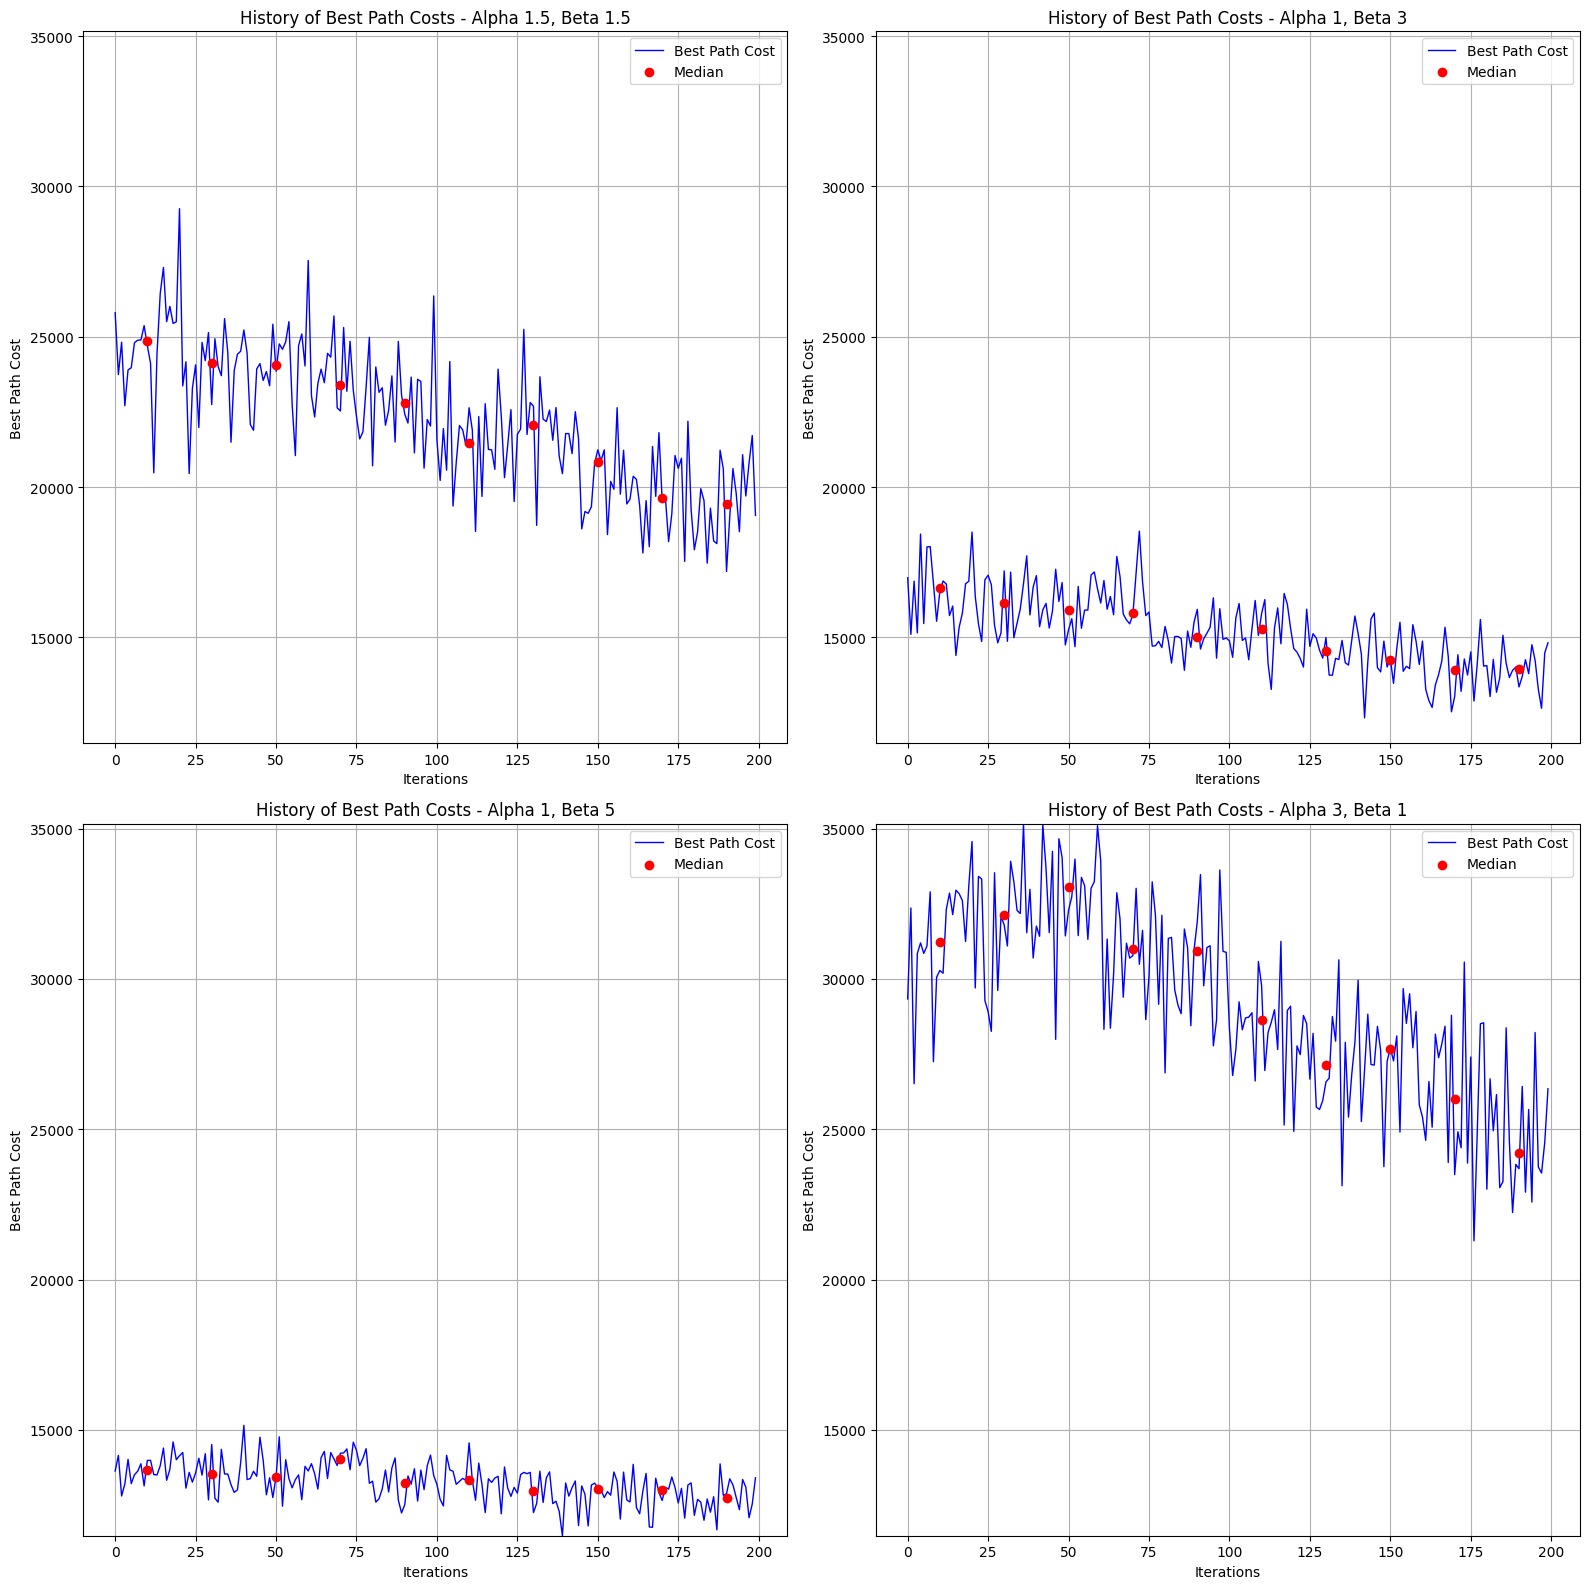

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
rate=20
y_range = (min(min(tsp_1.history), min(tsp_2.history), min(tsp_3.history), min(tsp_4.history)), max(max(tsp_1.history), max(tsp_2.history), max(tsp_3.history), max(tsp_4.history)))

plot_history(tsp_1.history, interval_size=rate, ax=axs[0][0], y_range=y_range)
axs[0][0].set_title("History of Best Path Costs - Alpha 1.5, Beta 1.5")
plot_history(tsp_2.history, interval_size=rate, ax=axs[0][1], y_range=y_range)
axs[0][1].set_title("History of Best Path Costs - Alpha 1, Beta 3")
plot_history(tsp_3.history, interval_size=rate, ax=axs[1][0], y_range=y_range)
axs[1][0].set_title("History of Best Path Costs - Alpha 1, Beta 5")
plot_history(tsp_4.history, interval_size=rate, ax=axs[1][1], y_range=y_range)
axs[1][1].set_title("History of Best Path Costs - Alpha 3, Beta 1")

plt.tight_layout()
plt.show()

We can see that the best initialisation is by far for alpha = 1 and beta = 5. Let's look for the best initialisation for beta.

In [9]:
rate = 20
tsp_1 = TSP(graph, alpha=1., beta=3., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.9, max_iter=200, k=int(np.sqrt(n)), heuristic_cost=cost)
path = tsp_1.solve()
tsp_2 = TSP(graph, alpha=1., beta=4., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.9, max_iter=200, k=int(np.sqrt(n)), heuristic_cost=cost)
path = tsp_2.solve()
tsp_3 = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.9, max_iter=200, k=int(np.sqrt(n)), heuristic_cost=cost)
path = tsp_3.solve()
tsp_4 = TSP(graph, alpha=1., beta=6., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.9, max_iter=200, k=int(np.sqrt(n)), heuristic_cost=cost)
path = tsp_4.solve()

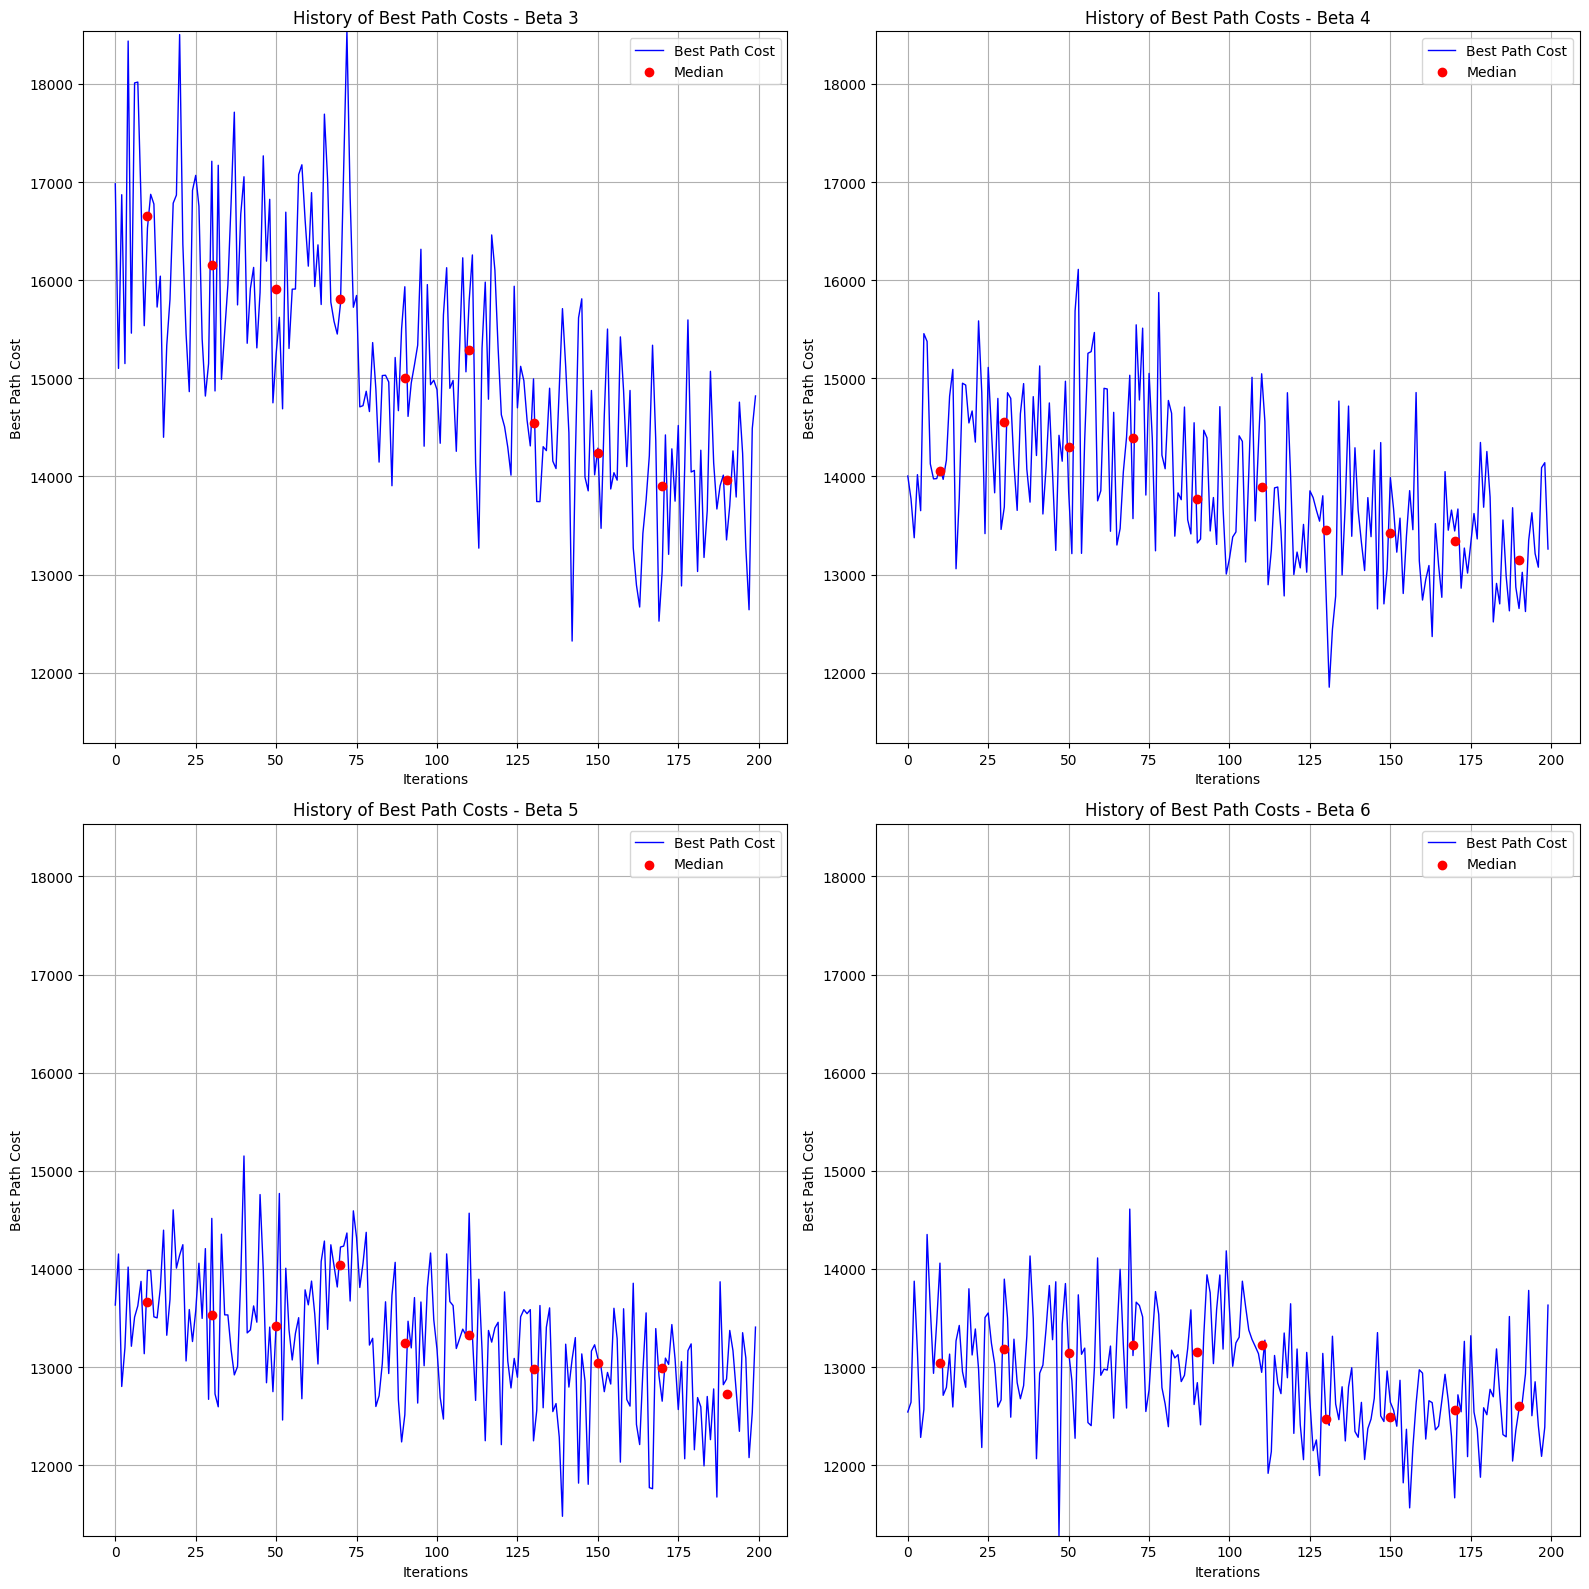

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
rate=20
y_range = (min(min(tsp_1.history), min(tsp_2.history), min(tsp_3.history), min(tsp_4.history)), max(max(tsp_1.history), max(tsp_2.history), max(tsp_3.history), max(tsp_4.history)))

plot_history(tsp_1.history, interval_size=rate, ax=axs[0][0], y_range=y_range)
axs[0][0].set_title("History of Best Path Costs - Beta 3")
plot_history(tsp_2.history, interval_size=rate, ax=axs[0][1], y_range=y_range)
axs[0][1].set_title("History of Best Path Costs - Beta 4")
plot_history(tsp_3.history, interval_size=rate, ax=axs[1][0], y_range=y_range)
axs[1][0].set_title("History of Best Path Costs - Beta 5")
plot_history(tsp_4.history, interval_size=rate, ax=axs[1][1], y_range=y_range)
axs[1][1].set_title("History of Best Path Costs - Beta 6")

plt.tight_layout()
plt.show()

It seems that 5 is the best value for beta. That is why we will use it to initialise the parameters in the next comparisons.

We can see that there is a common trend: we start with a solution with a cost ~ 14000, which corresponds to the cost of totally heuristic path, but then the cost grows up, probably because the pheromone is updated in the wrong manner (using only the heuristic information, so only exploitation of the heuristic information), successsively the cost decreases again, meaning that the algorithm is starting to use the pheromone more wisely (exploration).

### Showing the impact of using only the pheromone/heuristic information 

In [11]:
tsp_1 = TSP(graph, alpha=0., beta=1., alpha_rate=1. , beta_rate=1., rate=500, rho=0.9, max_iter=500, k=int(np.sqrt(n)), heuristic_cost=cost)
path = tsp_1.solve()
tsp_2 = TSP(graph, alpha=1., beta=0., alpha_rate=1. , beta_rate=1., rate=500, rho=0.9, max_iter=500, k=int(np.sqrt(n)), heuristic_cost=1)
path = tsp_2.solve()

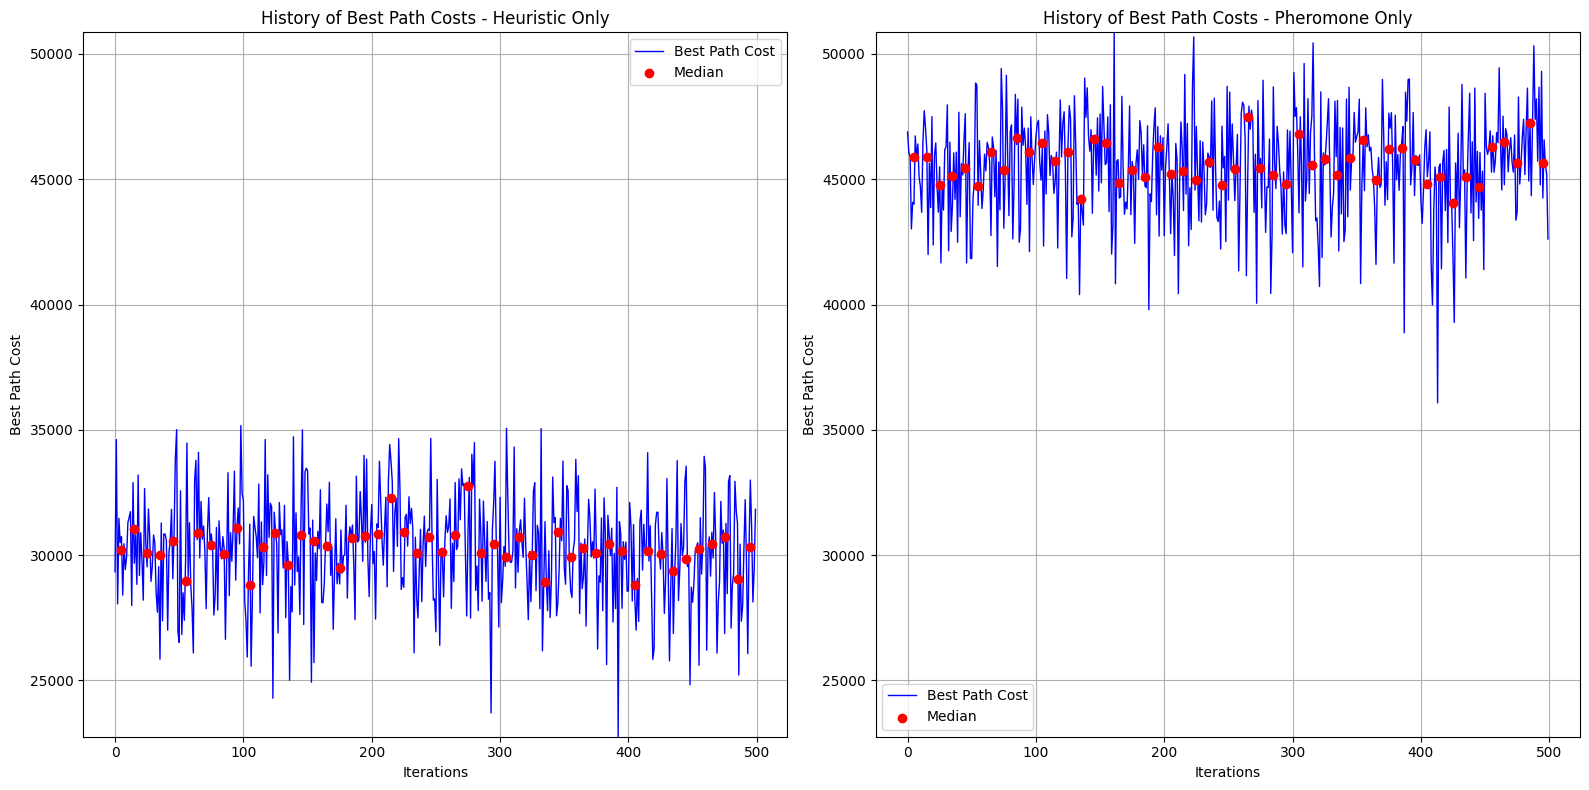

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
rate=10
y_range = (min(min(tsp_1.history), min(tsp_2.history)), max(max(tsp_1.history), max(tsp_2.history)))

plot_history(tsp_1.history, interval_size=rate, ax=axs[0], y_range=y_range)
axs[0].set_title("History of Best Path Costs - Heuristic Only")
plot_history(tsp_2.history, interval_size=rate, ax=axs[1], y_range=y_range)
axs[1].set_title("History of Best Path Costs - Pheromone Only")

plt.tight_layout()
plt.show()

We can see that we can't learn anything without one of the ingredients of our algorithm, they are both necessary.

### Showing the impact of the stopping of the update of the parameters

In [13]:
rate = 10
tsp_1 = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.9, max_iter=1000, k=int(np.sqrt(n)), heuristic_cost=cost, update_steps=0)
path = tsp_1.solve()
tsp_2 = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.9, max_iter=1000, k=int(np.sqrt(n)), heuristic_cost=cost, update_steps=250)
path = tsp_2.solve()
tsp_3 = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.9, max_iter=1000, k=int(np.sqrt(n)), heuristic_cost=cost, update_steps=500)
path = tsp_3.solve()
tsp_4 = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.9, max_iter=1000, k=int(np.sqrt(n)), heuristic_cost=cost, update_steps=750)
path = tsp_4.solve()

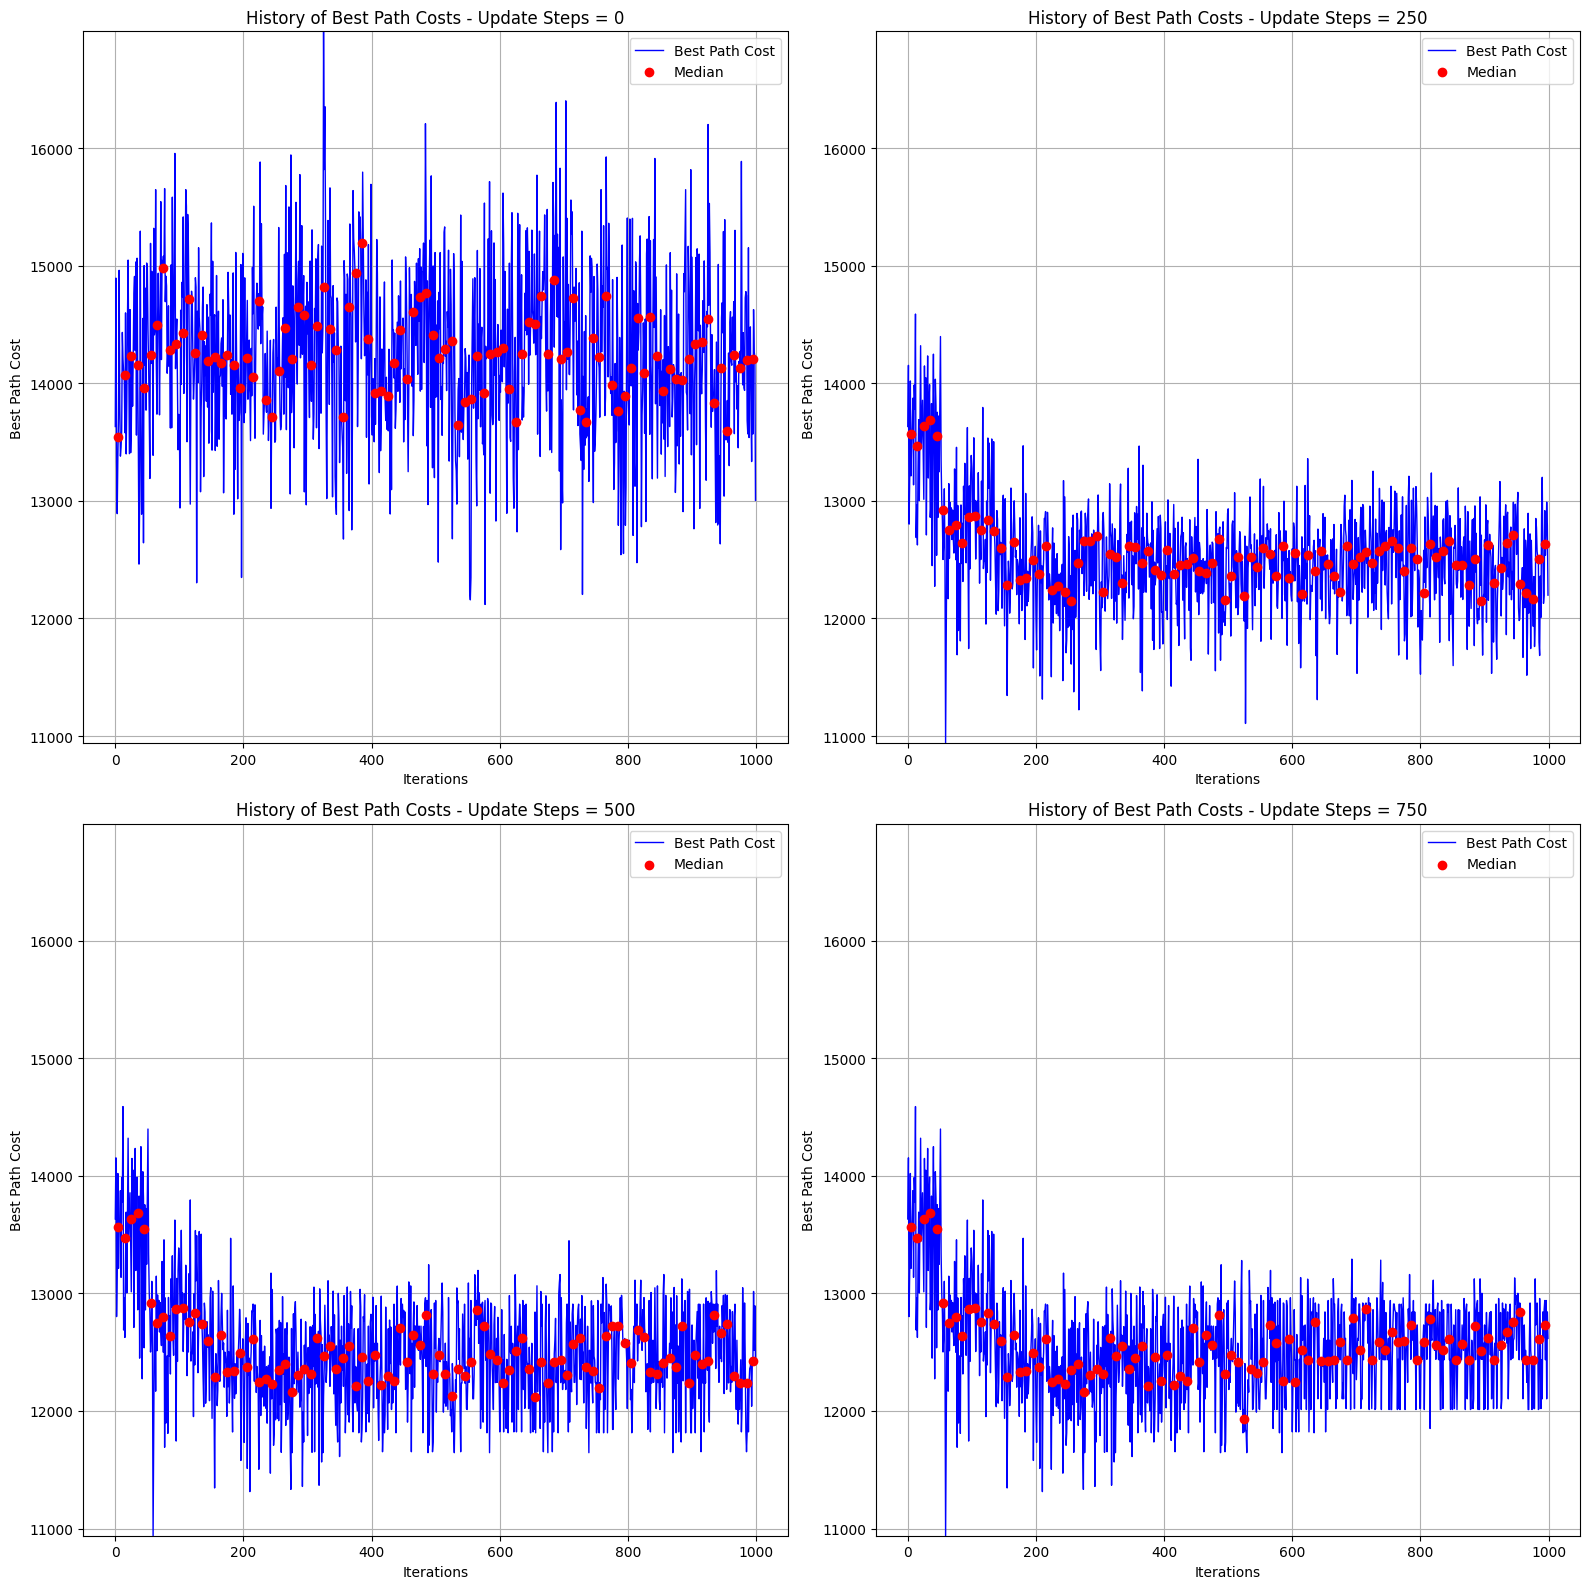

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
y_range = (min(min(tsp_1.history), min(tsp_2.history), min(tsp_3.history), min(tsp_4.history)), max(max(tsp_1.history), max(tsp_2.history), max(tsp_3.history), max(tsp_4.history)))

plot_history(tsp_1.history, interval_size=rate, ax=axs[0][0], y_range=y_range)
axs[0][0].set_title("History of Best Path Costs - Update Steps = 0")
plot_history(tsp_2.history, interval_size=rate, ax=axs[0][1], y_range=y_range)
axs[0][1].set_title("History of Best Path Costs - Update Steps = 250")
plot_history(tsp_3.history, interval_size=rate, ax=axs[1][0], y_range=y_range)
axs[1][0].set_title("History of Best Path Costs - Update Steps = 500")
plot_history(tsp_4.history, interval_size=rate, ax=axs[1][1], y_range=y_range)
axs[1][1].set_title("History of Best Path Costs - Update Steps = 750")

plt.tight_layout()
plt.show()

We can see that with 250/500 update steps we find the best configuration. We choose to keep 250.

### Showing the impact of elitism in computing the update of the pheromone

In [15]:
rate = 10
tsp_1 = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.5, max_iter=1000, k=int(np.sqrt(n)), heuristic_cost=cost, update_steps=250, elitism=False)
path = tsp_1.solve()
tsp_2 = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.5, max_iter=1000, k=int(np.sqrt(n)), heuristic_cost=cost, update_steps=250, elitism=True, elitism_steps=0)
path = tsp_2.solve()
tsp_3 = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.5, max_iter=1000, k=int(np.sqrt(n)), heuristic_cost=cost, update_steps=250, elitism=True, elitism_steps=250)
path = tsp_3.solve()
tsp_4 = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.5, max_iter=1000, k=int(np.sqrt(n)), heuristic_cost=cost, update_steps=250, elitism=True, elitism_steps=500)
path = tsp_4.solve()

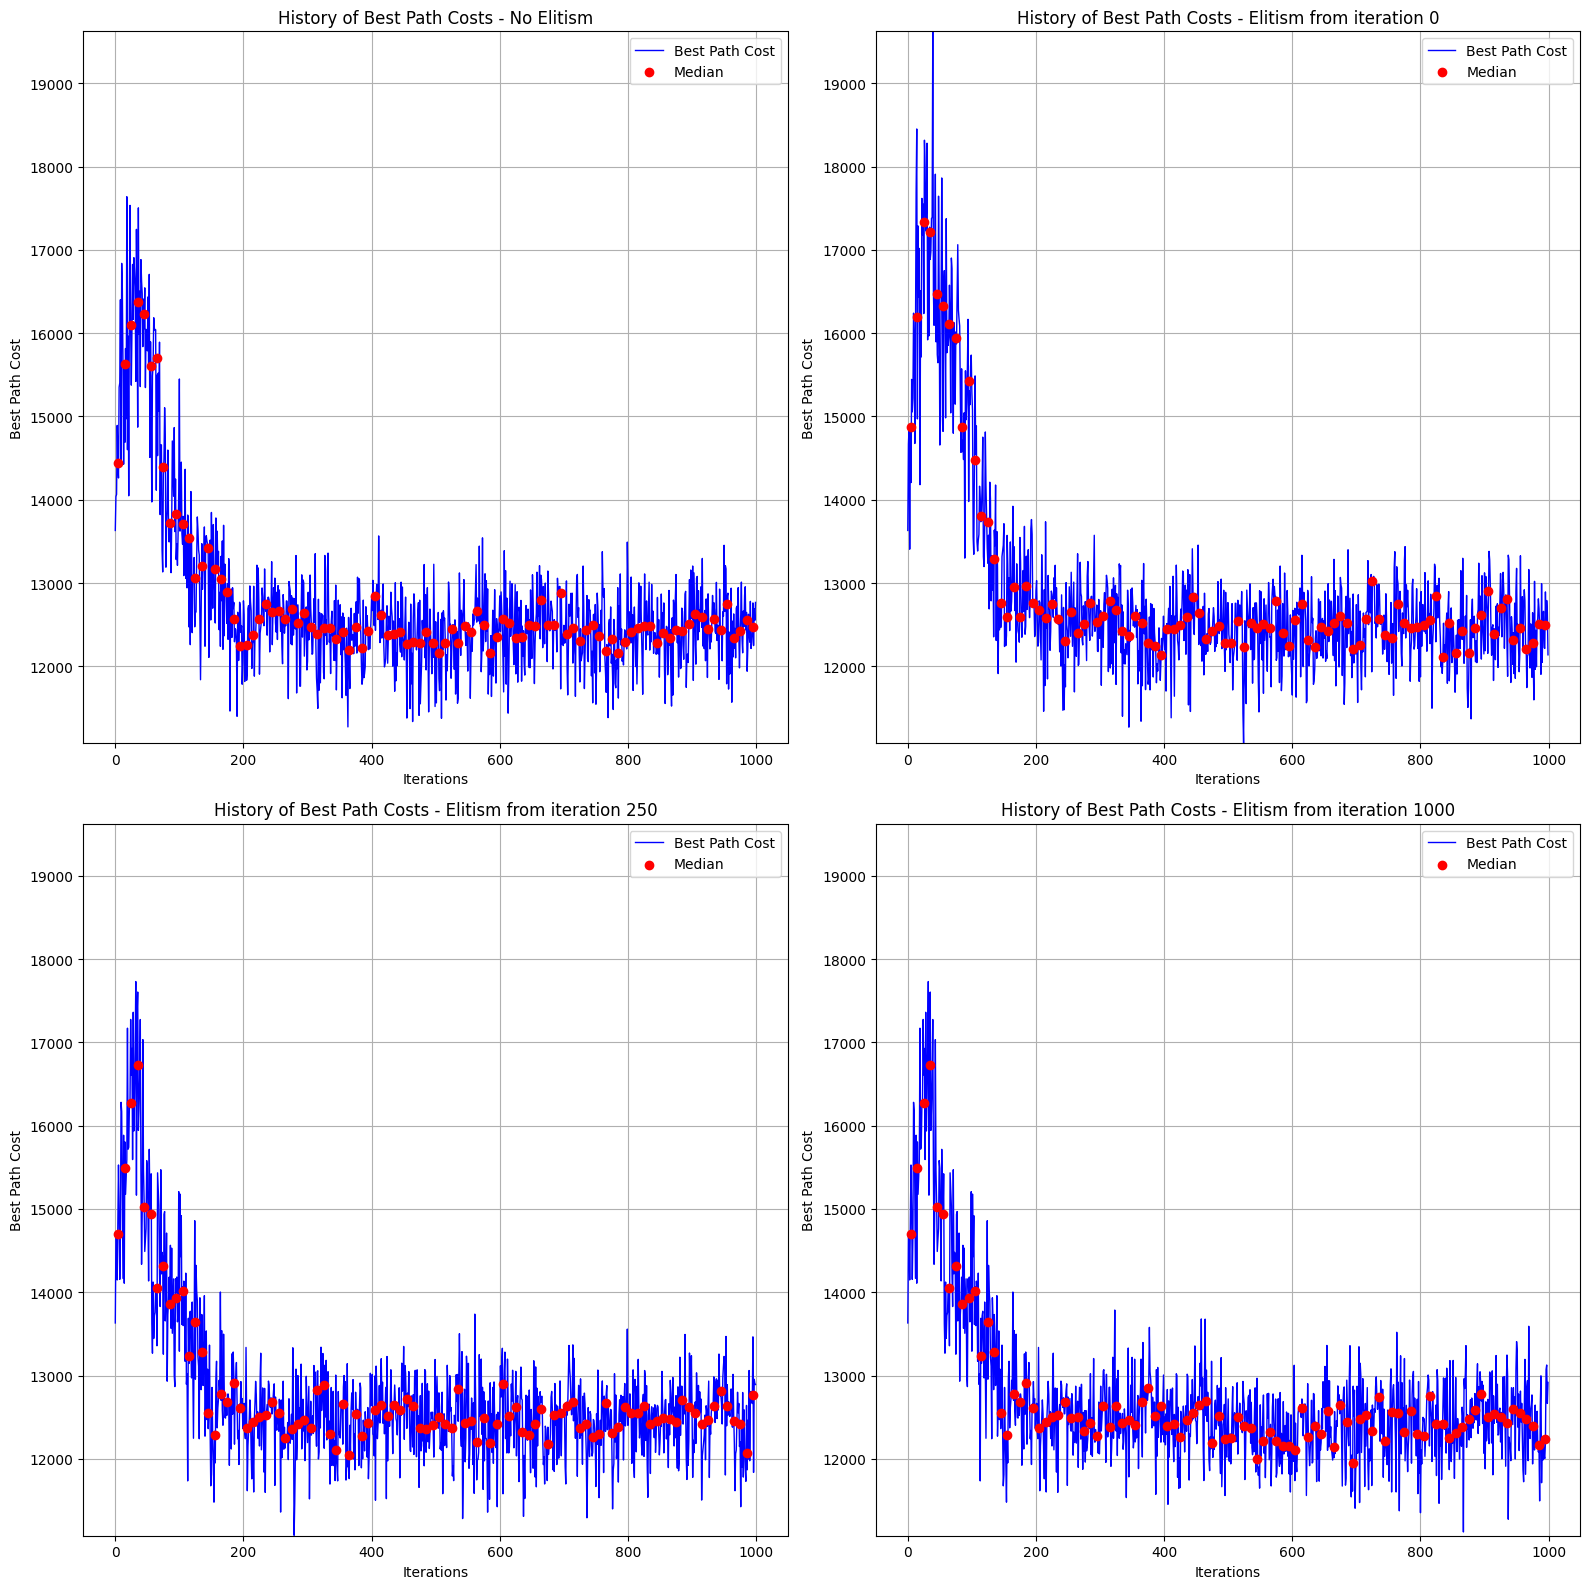

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
y_range = (min(min(tsp_1.history), min(tsp_2.history), min(tsp_3.history), min(tsp_4.history)), max(max(tsp_1.history), max(tsp_2.history), max(tsp_3.history), max(tsp_4.history)))

plot_history(tsp_1.history, interval_size=rate, ax=axs[0][0], y_range=y_range)
axs[0][0].set_title("History of Best Path Costs - No Elitism")
plot_history(tsp_2.history, interval_size=rate, ax=axs[0][1], y_range=y_range)
axs[0][1].set_title("History of Best Path Costs - Elitism from iteration 0")
plot_history(tsp_3.history, interval_size=rate, ax=axs[1][0], y_range=y_range)
axs[1][0].set_title("History of Best Path Costs - Elitism from iteration 250")
plot_history(tsp_4.history, interval_size=rate, ax=axs[1][1], y_range=y_range)
axs[1][1].set_title("History of Best Path Costs - Elitism from iteration 1000")

plt.tight_layout()
plt.show()

It is interesting to note that leveraging elitism in the first iterations doesn't bring an improvement, on the contrary it produces worse solutions. We can say that leveraging elitism is not that effective in general.

### Showing the impact of the rate variable in the learning

We perform the same number of updates but at different rates.

In [17]:
tsp_1 = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=10, rho=0.9, max_iter=1000, k=int(np.sqrt(n)), heuristic_cost=cost, update_steps=250)
path = tsp_1.solve()
tsp_2 = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=20, rho=0.9, max_iter=1000, k=int(np.sqrt(n)), heuristic_cost=cost, update_steps=500)
path = tsp_2.solve()

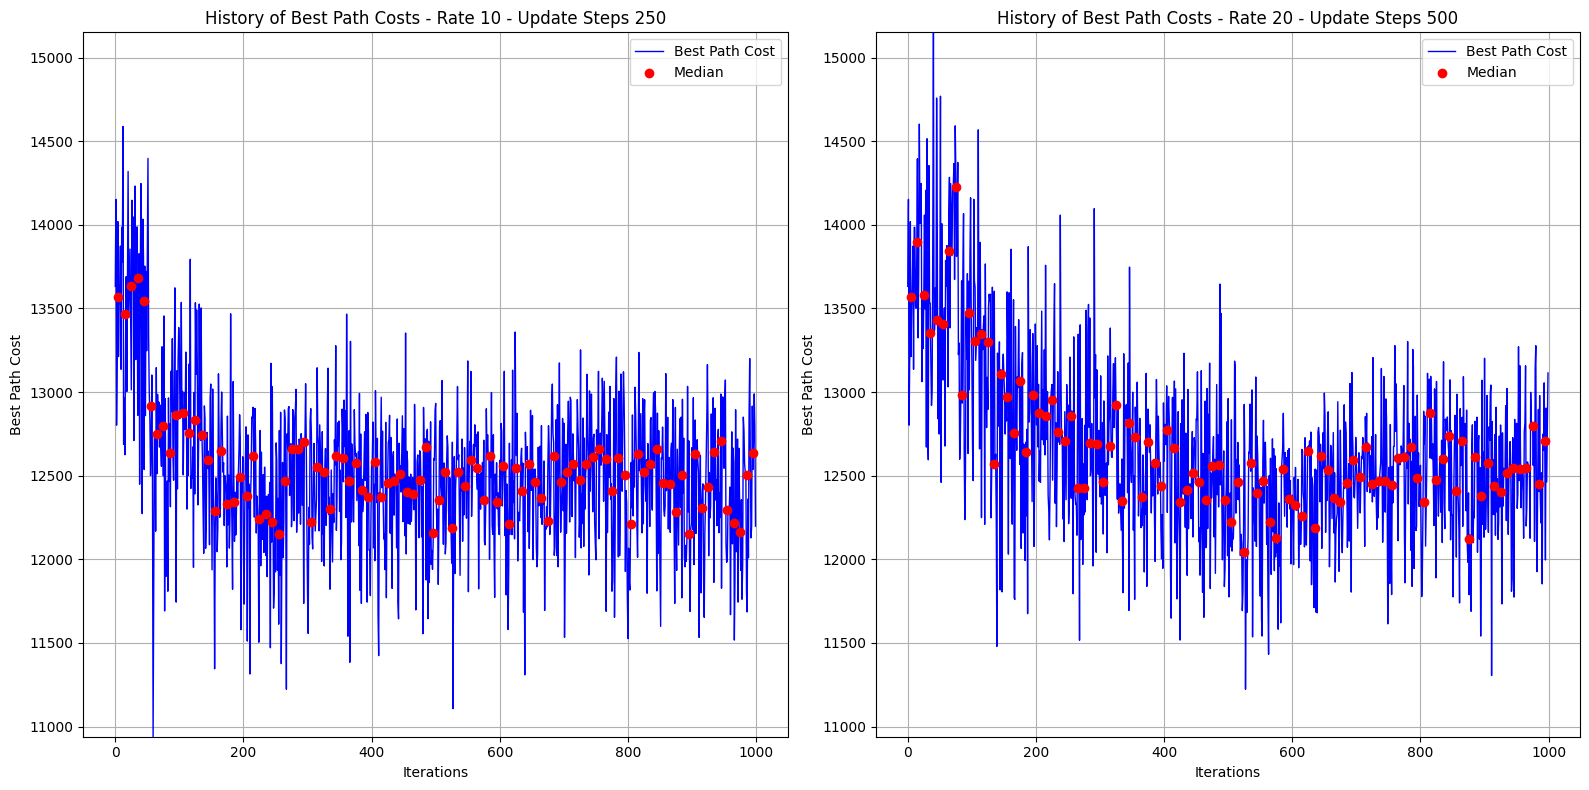

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
y_range = (min(min(tsp_1.history), min(tsp_2.history)), max(max(tsp_1.history), max(tsp_2.history)))

plot_history(tsp_1.history, interval_size=10, ax=axs[0], y_range=y_range)
axs[0].set_title("History of Best Path Costs - Rate 10 - Update Steps 250")
plot_history(tsp_2.history, interval_size=10, ax=axs[1], y_range=y_range)
axs[1].set_title("History of Best Path Costs - Rate 20 - Update Steps 500")

plt.tight_layout()
plt.show()

We can see that the difference is not remarkable, but we choose to keep the first configuration.

### Showing the impact of the forget-rate of the pheromone

The forget-rate can be seen as a selection process, in which the lower the forget-rate the more selective pressure is applied to the solutions, because the trails through which pass few ants or that are too long are rapidly discouraged.

In [19]:
tsp_1 = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=10, rho=0.5, max_iter=1000, k=int(np.sqrt(n)), heuristic_cost=cost, update_steps=250)
path = tsp_1.solve()
tsp_2 = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=10, rho=0.9, max_iter=1000, k=int(np.sqrt(n)), heuristic_cost=cost, update_steps=250)
path = tsp_2.solve()

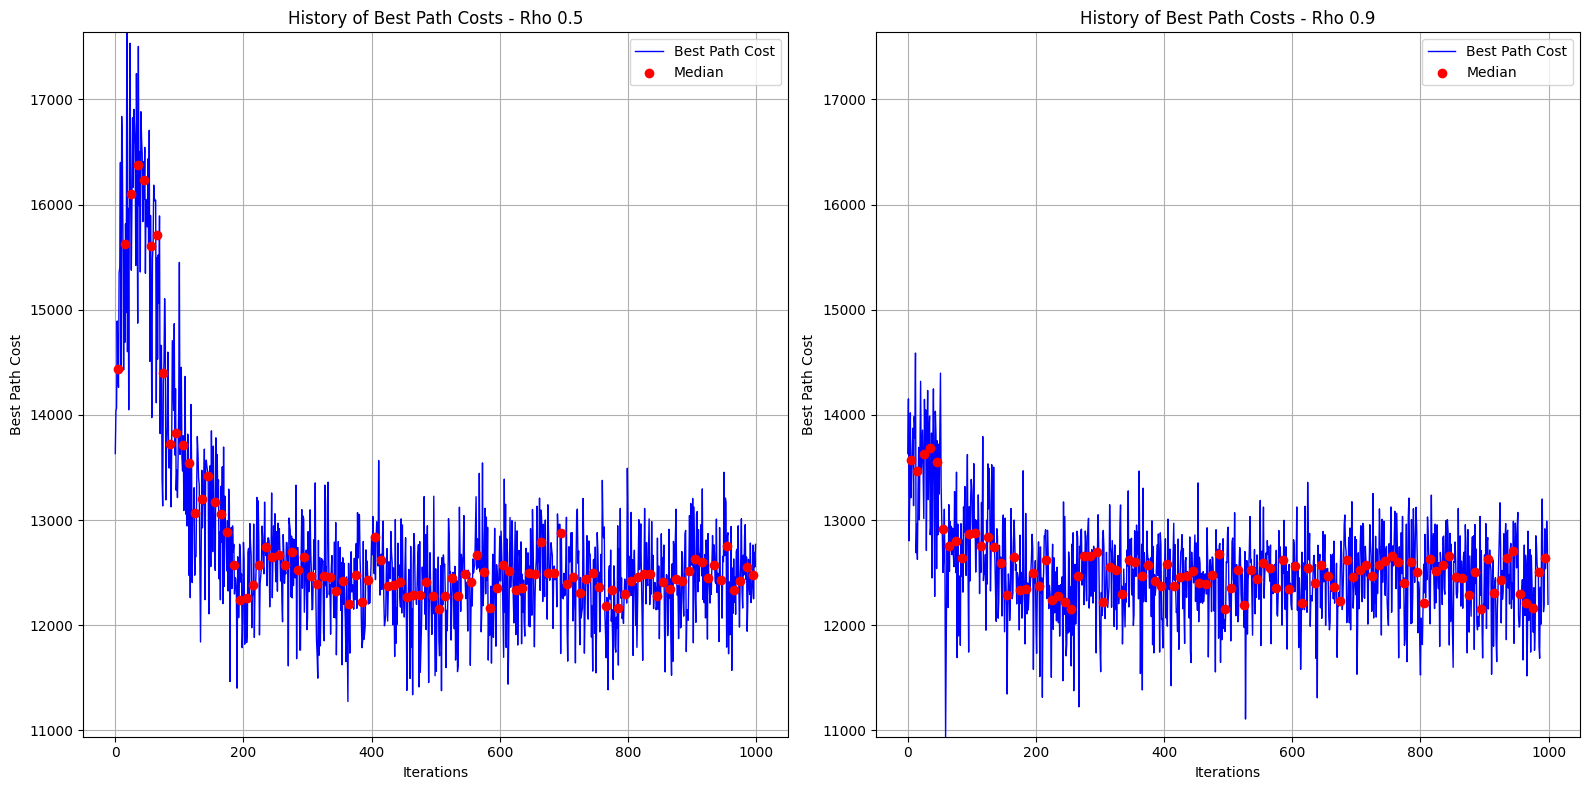

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
rate=10
y_range = (min(min(tsp_1.history), min(tsp_2.history)), max(max(tsp_1.history), max(tsp_2.history)))

plot_history(tsp_1.history, interval_size=rate, ax=axs[0], y_range=y_range)
axs[0].set_title("History of Best Path Costs - Rho 0.5")
plot_history(tsp_2.history, interval_size=rate, ax=axs[1], y_range=y_range)
axs[1].set_title("History of Best Path Costs - Rho 0.9")

plt.tight_layout()
plt.show()

It is interesting to note the behaviour of the first configuration (rho=0.5) at the first iterations. On the other hand, we can't see a great difference in the rest of the iterations.

### Showing the impact of biasing the pheromone with the best solution found

In [21]:
rate = 10
tsp_1 = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.5, max_iter=1000, k=int(np.sqrt(n)), heuristic_cost=cost, update_steps=400, bias=False)
path = tsp_1.solve()
tsp_2 = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=rate, rho=0.5, max_iter=1000, k=int(np.sqrt(n)), heuristic_cost=cost, update_steps=400, bias=True)
path = tsp_2.solve()

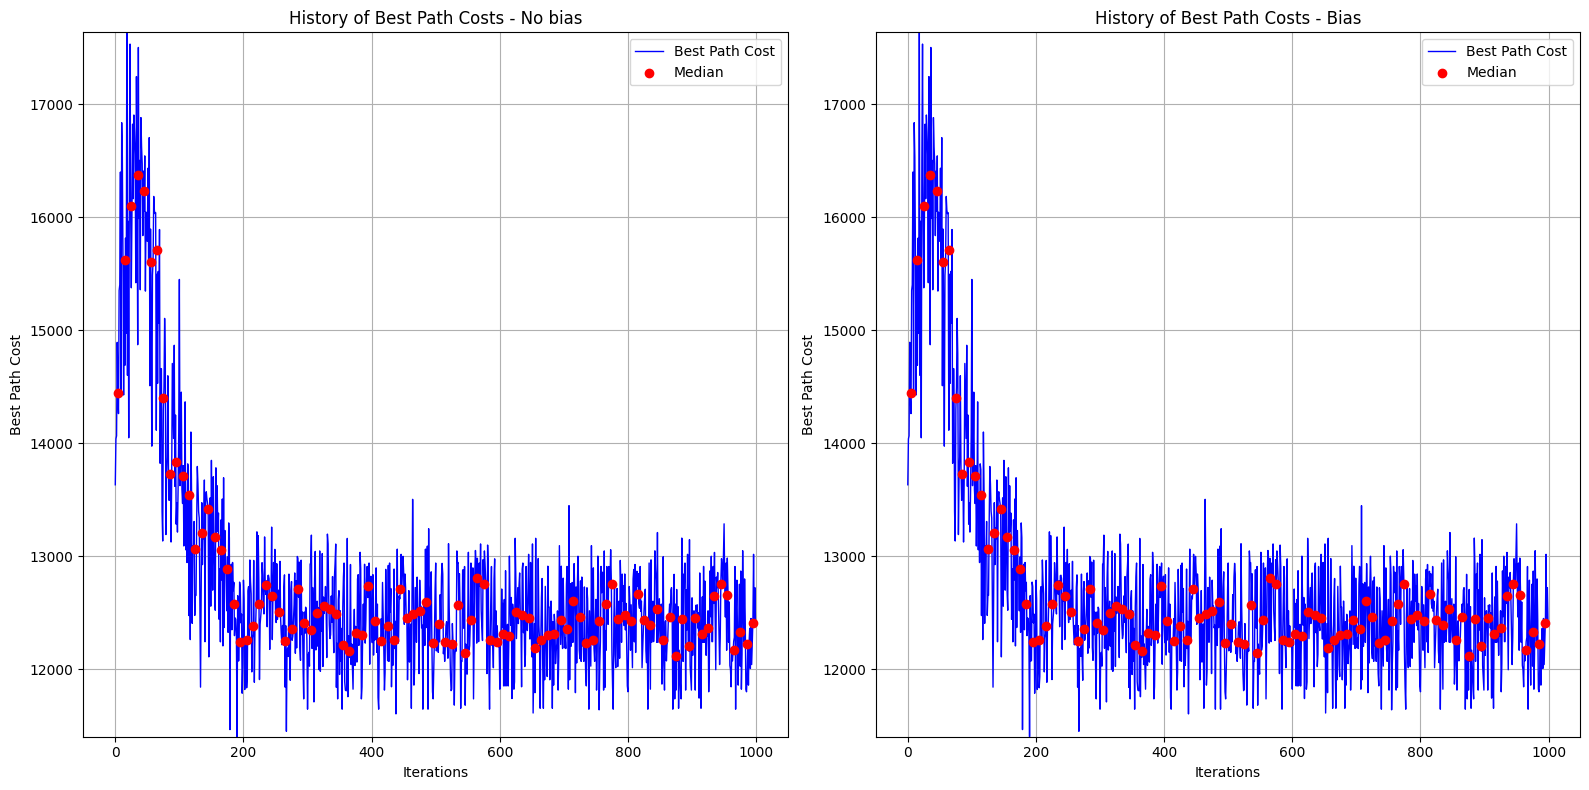

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
rate=10
y_range = (min(min(tsp_1.history), min(tsp_2.history)), max(max(tsp_1.history), max(tsp_2.history)))

plot_history(tsp_1.history, interval_size=rate, ax=axs[0], y_range=y_range)
axs[0].set_title("History of Best Path Costs - No bias")
plot_history(tsp_2.history, interval_size=rate, ax=axs[1], y_range=y_range)
axs[1].set_title("History of Best Path Costs - Bias")

plt.tight_layout()
plt.show()

Biasing the pheromone seems not to bring a signficant improvement, so we keep it down.

### Showing the pheromone matrix and the best solution found

In [23]:
tsp = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=10, rho=0.9, max_iter=1000, k=int(np.sqrt(n)), heuristic_cost=cost, update_steps=250)
path, _ = tsp.solve()

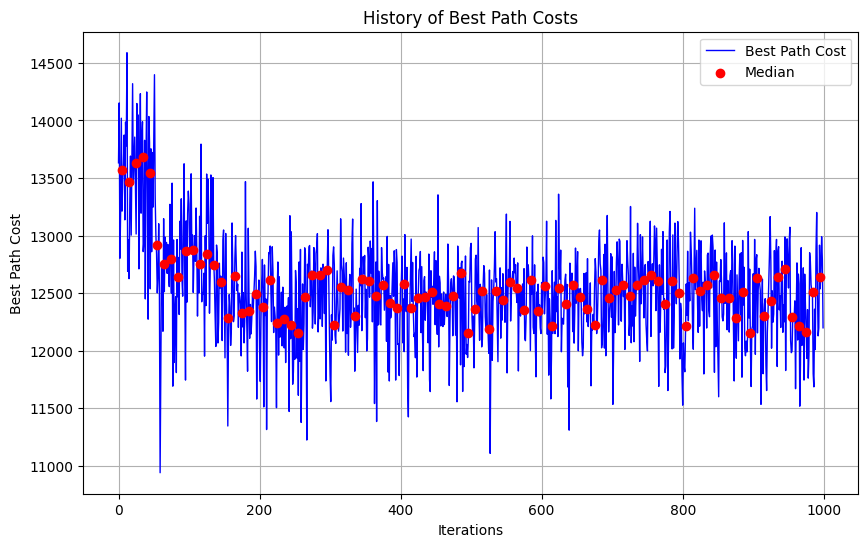

In [24]:
plot_history(tsp.history, 10)

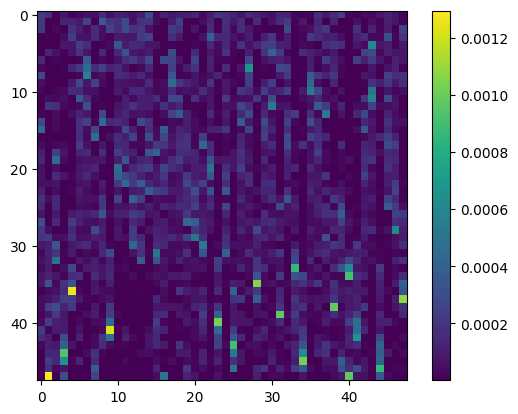

In [25]:
imshow(np.asarray(tsp.pheromone))
plt.colorbar()
plt.show()

[33, 40, 15, 21, 2, 22, 10, 11, 32, 45, 14, 39, 8, 0, 7, 37, 30, 43, 17, 6, 27, 35, 29, 5, 36, 18, 26, 16, 42, 19, 46, 20, 12, 13, 24, 31, 38, 47, 4, 41, 9, 23, 44, 34, 3, 25, 1, 28, 33]
Best path found has cost: 10939
Distance from the global optimum: 311
Relative distance from the global optimum: 0.03


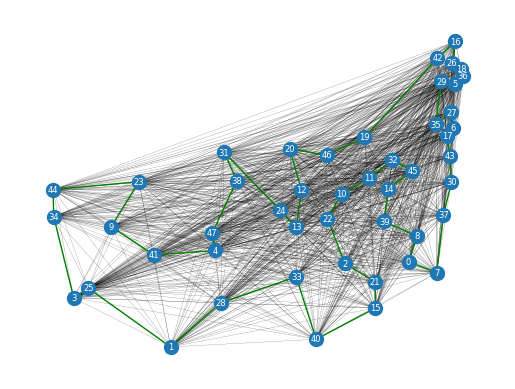

In [26]:
best_cost = 10628
print(path.path)
print("Best path found has cost:", path.cost)
print("Distance from the global optimum:", path.cost-best_cost)
print(f"Relative distance from the global optimum: {(path.cost-best_cost)/best_cost:.2f}")
plot_path(graph, path.path)

[33, 40, 15, 21, 2, 22, 10, 11, 32, 45, 14, 39, 8, 0, 7, 37, 30, 43, 17, 6, 35, 27, 29, 5, 36, 18, 26, 16, 42, 19, 46, 20, 12, 13, 24, 38, 31, 47, 4, 41, 23, 9, 44, 34, 3, 25, 1, 28, 33]
10863


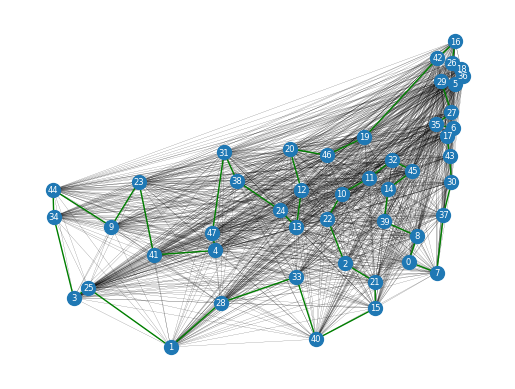

In [27]:
path.opt_alg()
print(path.path)
print(path.cost)
plot_path(graph, path.path)

It is interesting to note that the local optimisation algorithm brings a significant improvement; this is probably due to the limitations of a stigmergic system like the one implemented: it doesn't have the ability to compare how a path changes by performing local permutations of 2 edges.

### Running the algorithm 10 times

In [28]:
costs = []
opt_costs = []
for i in range(10):
    tsp = TSP(graph, alpha=1., beta=5., alpha_rate=0.95 , beta_rate=1.05, rate=10, rho=0.9, max_iter=500, k=int(np.sqrt(n)), heuristic_cost=cost, update_steps=250, seed=i)
    path, _ = tsp.solve()
    costs.append(path.cost)
    path.opt_alg()
    opt_costs.append(path.cost)

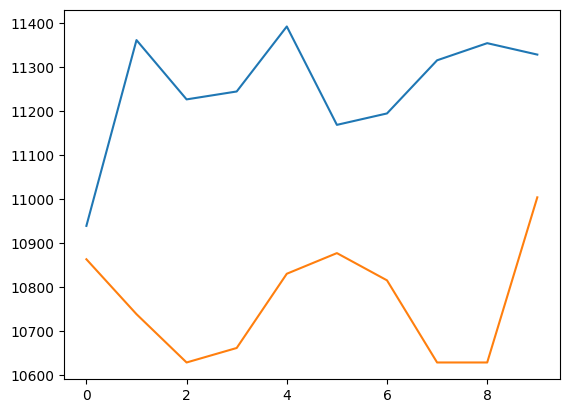

In [29]:
plt.plot(costs)
plt.plot(opt_costs)

In [30]:
print("Mean cost:", np.mean(costs))
print("Mean optimal cost:", np.mean(opt_costs))
print("Min cost:", np.min(costs))
print("Min optimal cost:", np.min(opt_costs))

Mean cost: 11253.0
Mean optimal cost: 10767.2
Min cost: 10939
Min optimal cost: 10628


It is very nice to see that we found the optimal solution!

### Comparison with the Christofides Algorithm

We can note that the Christofides algorithm -which is deterministic- runs in much less time but returns a worse solution than than our algorithm.

Applying the local optimisation algorithm improves the solution but it is still worse.

In [31]:
# Showing that the algorithm is deterministic
tsp_sol = nx.approximation.traveling_salesman_problem(graph, cycle=True)
print(tsp_sol)
tsp_sol = nx.approximation.traveling_salesman_problem(graph, cycle=True)
print(tsp_sol)

[0, 7, 21, 15, 2, 40, 33, 13, 24, 38, 47, 4, 41, 9, 34, 44, 23, 25, 3, 1, 28, 31, 20, 46, 10, 12, 22, 11, 14, 39, 8, 32, 19, 45, 17, 35, 29, 5, 26, 42, 16, 18, 36, 27, 6, 43, 30, 37, 0]
[0, 7, 21, 15, 2, 40, 33, 13, 24, 38, 47, 4, 41, 9, 34, 44, 23, 25, 3, 1, 28, 31, 20, 46, 10, 12, 22, 11, 14, 39, 8, 32, 19, 45, 17, 35, 29, 5, 26, 42, 16, 18, 36, 27, 6, 43, 30, 37, 0]


In [32]:
tsp_sol = nx.approximation.traveling_salesman_problem(graph, cycle=True)
tsp_solution = Path(tsp_sol)
cost = tsp_solution.cost
tsp_solution_opt = Path(tsp_sol)
tsp_solution_opt.opt_alg()
cost_opt = tsp_solution_opt.cost

print("Cost with Christofides:", cost)
print("Best cost with 2-opt + Crisophides:", cost_opt)

Cost with Christofides: 12613
Best cost with 2-opt + Crisophides: 11171


Note that this optimisation can be done just once.

In [33]:
tsp_solution_opt.opt_alg()
cost_opt = tsp_solution_opt.cost
cost_opt

11171

What we can could do is to shuffle the indices when performing the local optimisation and run the optimisation many times taking note of the best cost found.

### Comparison with the simple local optimisation algorithm

For curiosity, we set a random hamiltonian circuit and try to optimise it with only local optimisations.

Cost of the best optimised random path: 10663


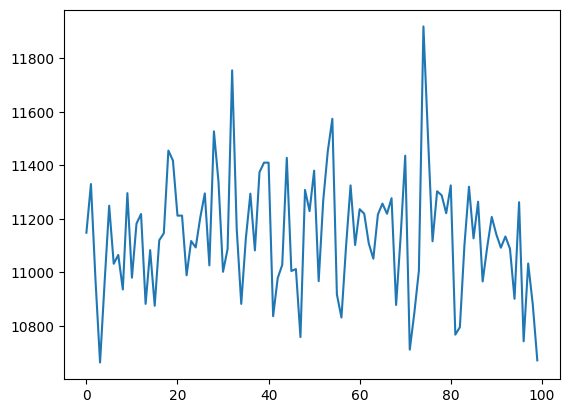

In [34]:
history = []
best_cost = 1000000
for i in range(100):
    random_path = list(range(len(graph.nodes)))
    random.shuffle(random_path)
    random_path = random_path + [random_path[0]]
    random_path = Path(random_path)
    random_path.opt_alg()
    if random_path.cost < best_cost:
        best_cost = random_path.cost
    history.append(random_path.cost)

print("Cost of the best optimised random path:", best_cost)
plt.plot(history)

We found a very nice solution with very few effort!